<a href="https://colab.research.google.com/github/UAEU2020/SGP/blob/main/Copy_of_Recycling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.regularizers import l2

In [2]:
import kagglehub
# Download latest version
dataset_path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
print("Path to dataset files:", dataset_path)

100%|██████████| 920M/920M [00:19<00:00, 48.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images"

# Define the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset='training',
    seed=42
)

# Define the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset='validation',
    seed=42
)

# Verify the dataset structure
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")

Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.
Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 30)
Labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Number of classes: 30


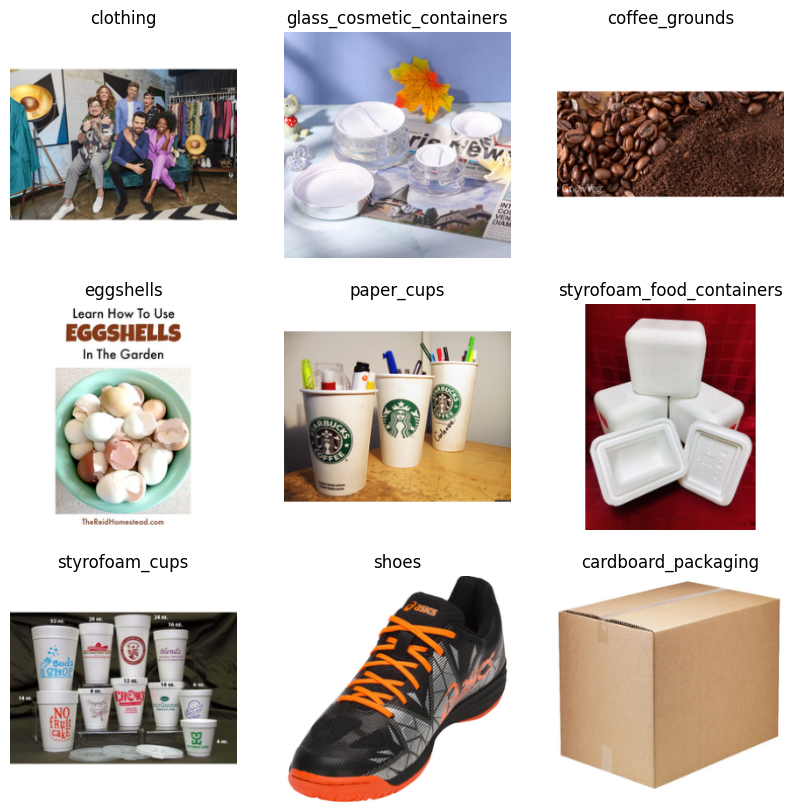

In [5]:
# Verify the dataset structure and plot some examples
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (class)
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    '''
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomContrast(0.2))

    return data_augmentation

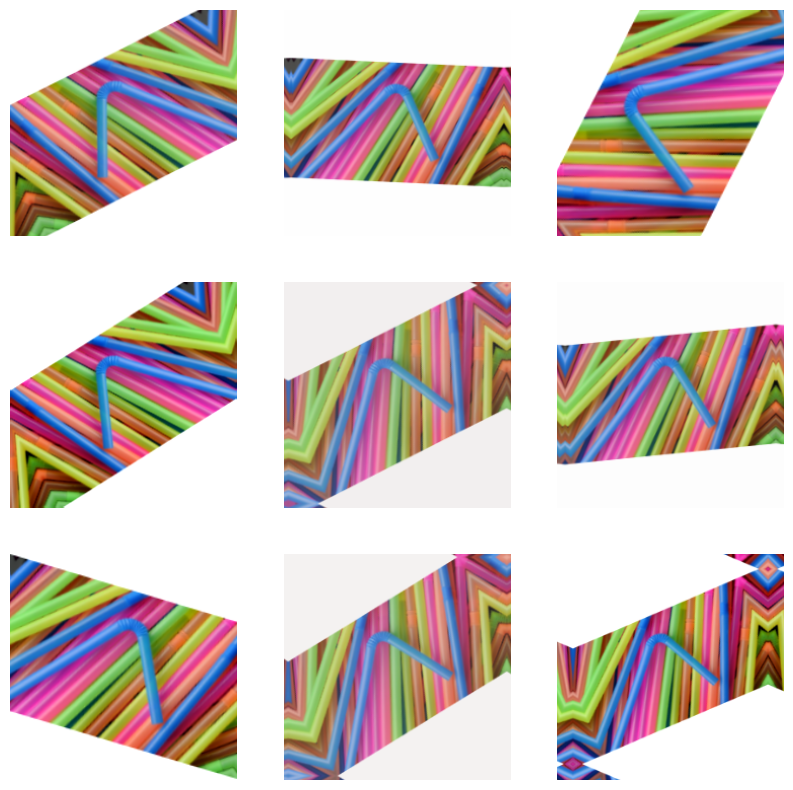

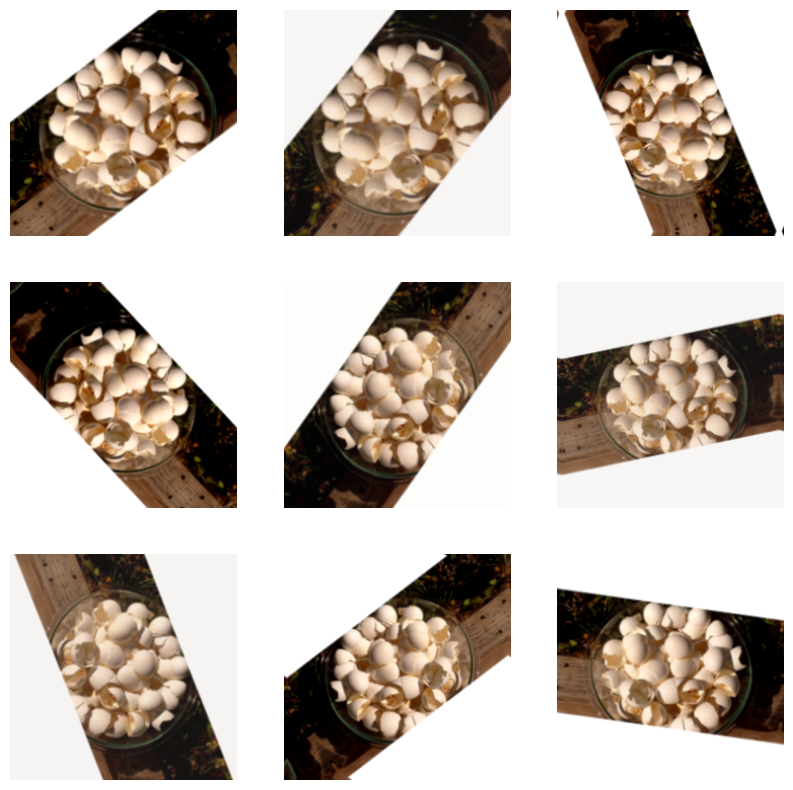

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(2):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Import ResNet50 for Transfer Learning

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
num_classes = len(class_names)

def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(),num_classes=num_classes,dropout_rate=0.4):
    '''
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        num_classes -- number of category classes
        dropout_rate -- droupout_rate for the classifaction layer
    Returns:
        tf.keras.model
    '''

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new  classification layers
    # global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # dropout layer to avoid overfitting
    x = tfl.Dropout(rate=dropout_rate)(x)
    # a prediction layer with num_classes neurons with l2 regularizer
    outputs = tfl.Dense(units=num_classes,kernel_regularizer=l2(0.01))(x)


    model = tf.keras.Model(inputs, outputs)

    return model

In [13]:
model2 = model(IMG_SIZE, data_augmentation)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2630s 7s/step - accuracy: 0.3952 - loss: 2.8295 - val_accuracy: 0.7520 - val_loss: 1.2254
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2644s 7s/step - accuracy: 0.6575 - loss: 1.5492 - val_accuracy: 0.7670 - val_loss: 1.0823
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2610s 7s/step - accuracy: 0.6822 - loss: 1.3563 - val_accuracy: 0.7923 - val_loss: 1.0021
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2647s 7s/step - accuracy: 0.7038 - loss: 1.2781 - val_accuracy: 0.7817 - val_loss: 0.9908
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2608s 7s/step - accuracy: 0.6996 - loss: 1.2772 - val_accuracy: 0.7897 - val_loss: 0.9940


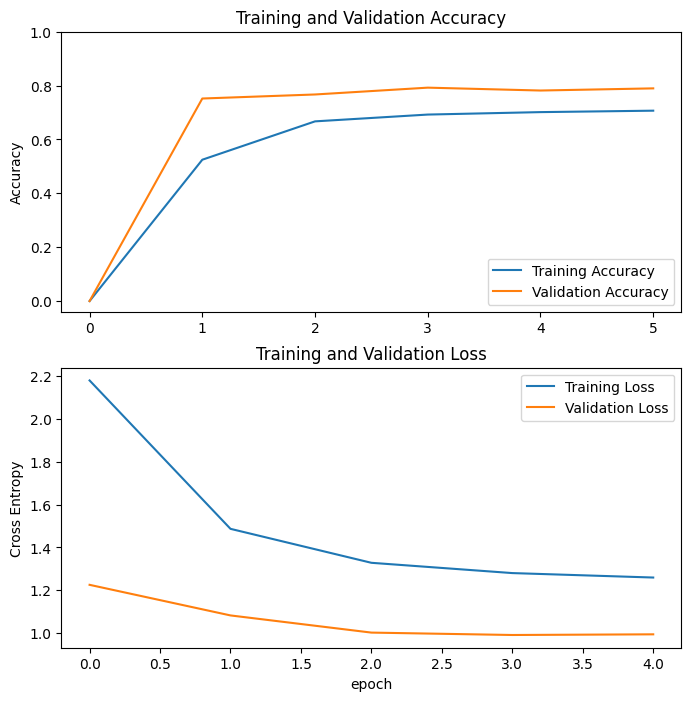

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine-tuning the Model


In [17]:
#how many layers are in the base model
base_model = model2.layers[2]
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [18]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

In [19]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a CategoricalCrossentropy loss function.
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [21]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3293s 9s/step - accuracy: 0.7425 - loss: 1.1464 - val_accuracy: 0.8237 - val_loss: 0.8388
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3320s 9s/step - accuracy: 0.8164 - loss: 0.8650 - val_accuracy: 0.8393 - val_loss: 0.7750
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3316s 9s/step - accuracy: 0.8494 - loss: 0.7178 - val_accuracy: 0.8517 - val_loss: 0.7098
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3312s 9s/step - accuracy: 0.8826 - loss: 0.5959 - val_accuracy: 0.8530 - val_loss: 0.6764
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3326s 9s/step - accuracy: 0.8976 - loss: 0.5336 - val_accuracy: 0.8560 - val_loss: 0.6578
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3259s 9s/step - accuracy: 0.9155 - loss: 0.4712 - val_accuracy: 0.8673 - val_loss: 0.6318


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

prediction


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    # Predict the labels for the batch of images
    predictions = model2.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (true class)
        predicted_label_index = predicted_labels[i].numpy()  # Get the index of the highest value (predicted class)

        true_label_name = class_names[true_label_index]
        predicted_label_name = class_names[predicted_label_index]

        plt.title(f'True: {true_label_name}\nPred: {predicted_label_name}')
        plt.axis("off")

plt.show()

Evaluation Metrics:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate true labels and predictions from the validation dataset
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in validation_dataset])  # True labels
y_pred = np.concatenate([np.argmax(model2.predict(x), axis=1) for x, _ in validation_dataset])  # Predicted labels

# 2. Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Classification Report
                              precision    recall  f1-score   support

       aerosol_cans            0.85      0.80      0.82       50
       aluminum_food_cans      0.78      0.85      0.81       40
       ...
       styrofoam_food_containers 0.70   0.75      0.72       35

       accuracy                                0.80      1000
       macro avg           0.78      0.79      0.78      1000
       weighted avg        0.80      0.80      0.80      1000



In [23]:
model2.save('model.keras')

In [28]:
# Remove data augmentation layer from the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_serializable = tf.keras.Model(inputs, outputs)

# Save in HDF5 format
model_serializable.save('model.h5')


In [30]:
model2.save('saved_model.keras')



In [31]:
# Install Gradio (if not already installed)
!pip install gradio tensorflow pillow

# Import required libraries
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('saved_model.keras')

# Define the class labels
classes = [
    'aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes',
    'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery',
    'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers',
    'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups',
    'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers',
    'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags',
    'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups',
    'styrofoam_food_containers', 'tea_bags'
]

# Preprocess function
def preprocess_image(image):
    # Convert image to RGB, resize to 224x224, normalize, and add batch dimension
    image = image.convert("RGB").resize((224, 224))
    image = img_to_array(image) / 255.0
    return np.expand_dims(image, axis=0)

# Prediction function
def predict(image):
    processed_image = preprocess_image(image)
    predictions = model.predict(processed_image)
    class_index = np.argmax(predictions)
    confidence = round(np.max(predictions) * 100, 2)
    return f"{classes[class_index]} ({confidence}%)"

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),  # Accepts image input
    outputs="text",  # Displays text output
    title="Recyclable Waste Classifier",
    description="Upload an image of waste to classify it into one of 30 categories."
)

# Launch the Gradio app
interface.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public 

In [35]:
!git config --global user.name "UAEU2020"
!git config --global user.email "202017138@uaeu.ac.ae"


In [37]:
!git clone https://github.com/UAEU2020/ACV-Project.git


Cloning into 'ACV-Project'...
